# Project-Step 1:

At this first stage of your project, complete the following tasks by providing your notebook (in .pybn format or
converted to HTML):
1. Descriptive analysis of your data.
2. Implementation of the necessary pre-processing.
3. Formalisation of the problem.
4. Selection of a baseline model and implementation of the model.

# Import des bibliothèques

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Gestion des erreurs en cas de soucis

In [31]:
warnings.filterwarnings('ignore', category=UserWarning)

# Chargement des données et jointure de Csv

Avant de commencer cette partie nous avons déjà réalisé une première lecture de nos données. Le but de notre projet est avant tout d'être capable de prédire l'écurie qui remporte la course. Pour cela comptons nous baser sur plusieurs variables, comme le palmarès du pilote, la position sur la course ou encore le circuit. Nos données sont séparées en plusieurs fichiers csv initialement au nombre de 14. Nous avons choisi de nous séparer de 3 de ces fichiers car nous les avons trouvé peu pertinents pour notre étude, à savoir :
- seasons.csv : ne contient qu'une liste des années des saisons, celles-ci se trouvent également dans le fichier races.csv
- sprint_results : les sprints sont une catégorie à part de la course, ces données n'ont donc aucune plus value pour notre étude
- qualifying.csv : données redondantes car elles n'apportent rien de plus. Seule la position de départ serait pertinente mais elle est déjà fournie dans races.csv

In [34]:
dataframes = {}
file_names = [
    "circuits.csv", "constructor_results.csv", "constructor_standings.csv",
    "constructors.csv", "driver_standings.csv", "drivers.csv",
    "lap_times.csv", "pit_stops.csv", "races.csv", "results.csv", "status.csv"
]
na_val = '\\N'

for f_name in file_names:
    try:
        key = f_name.split('.')[0]
        dataframes[key] = pd.read_csv(f_name, na_values=[na_val])
        print(f"Fichier '{f_name}' chargé.")
    except FileNotFoundError:
        # En cas de mauvaise écriture du csv ou non présence des fichiers dans le bon dossier
        print(f"ERREUR INATTENDUE : Fichier non trouvé : '{f_name}'")
        sys.exit()

print("\n--- Début de la fusion ---")

#Extraire les datasets
results = dataframes.get('results')
races = dataframes.get('races')
circuits = dataframes.get('circuits')
drivers = dataframes.get('drivers')
constructors = dataframes.get('constructors')
driver_standings = dataframes.get('driver_standings')
constructor_standings = dataframes.get('constructor_standings')
constructor_results = dataframes.get('constructor_results')
status = dataframes.get('status')

# Renommer les colonnes 'url' en conflit
races = races.rename(columns={'url': 'race_url'})
drivers = drivers.rename(columns={'url': 'driver_url'})
constructors = constructors.rename(columns={'url': 'constructor_url'})
circuits = circuits.rename(columns={'url': 'circuit_url'})

# Fusion dans un ordre logique
df_merged = (
    results
    .merge(races, on="raceId", how="left")
    .merge(circuits, on="circuitId", how="left")
    .merge(drivers, on="driverId", how="left")
    .merge(constructors, on="constructorId", how="left")
    .merge(status, on="statusId", how="left")
    .merge(driver_standings, on=["raceId", "driverId"], how="left", suffixes=('_driver', '_driver_stand'))
    .merge(constructor_standings, on=["raceId", "constructorId"], how="left", suffixes=('_constructor', '_constructor_stand'))
)

# Ajout de constructor_results
if 'constructor_results' in dataframes:
    cr = dataframes.get('constructor_results').copy()
    join_keys = ['raceId', 'constructorId']
    cols_to_prefix = [c for c in cr.columns if c not in join_keys]
    cr = cr.rename(columns={c: f"cr_{c}" for c in cols_to_prefix})
    df_merged = df_merged.merge(cr, on=join_keys, how='left')

# Vérification du résultat
print("\n Fusion complétée avec succès")
print(f" Forme finale du dataset: {df_merged.shape}")




Fichier 'circuits.csv' chargé.
Fichier 'constructor_results.csv' chargé.
Fichier 'constructor_standings.csv' chargé.
Fichier 'constructors.csv' chargé.
Fichier 'driver_standings.csv' chargé.
Fichier 'drivers.csv' chargé.
Fichier 'lap_times.csv' chargé.
Fichier 'pit_stops.csv' chargé.
Fichier 'races.csv' chargé.
Fichier 'results.csv' chargé.
Fichier 'status.csv' chargé.

--- Début de la fusion ---

 Fusion complétée avec succès
 Forme finale du dataset: (26499, 69)


# Analyse Descriptive

In [37]:
# Vérification des types et valeurs manquantes
print("\n--- Analyse des Données Brutes (Colonnes Clés) ---")
key_cols = ['raceId', 'year', 'grid', 'positionOrder', 'circuitId', 'driverId', 'constructorId']
print(df_merged[key_cols].info())

print("\nValeurs manquantes (avant pré-traitement) :")
print(df_merged[key_cols].isna().sum())
print("NOTE : 'grid' a 0 NaNs (les '\\N' ont été lus comme 0 ou une autre valeur).")
print("      S'il y avait des NaNs (vrais zéros), ils seraient remplacés à l'Étape 2.")

print("\nAnalyse des Features (X) - 'grid' (position de départ) :")
print(df_merged['grid'].describe())
print(f"Valeurs manquantes dans 'grid' : {df_merged['grid'].isna().sum()}")

# Création et Analyse de la Cible (Y_winner)
# Notre cible : 1 si le pilote a gagné (positionOrder == 1), 0 sinon.
target = (df_merged['positionOrder'] == 1).astype(int)
df_merged['Y_winner'] = target # Ajout temporaire pour l'analyse

print("\n--- Analyse de la Cible (Y_winner) ---")
print("Distribution des Gagnants (1) vs Non-Gagnants (0) :")
print(target.value_counts(normalize=True))
print(f"NOTE : Seulement {target.mean()*100:.2f}% des pilotes gagnent, le dataset est très déséquilibré.")


# Analyse Bivariée (Feature vs Cible)
print("\n--- Relation: Position de Départ (grid) vs Taux de Victoire ---")
# Calculer le taux de victoire moyen pour chaque position sur la grille
# On ne regarde que le top 10 pour la lisibilité
grid_win_rate = df_merged.groupby('grid')['Y_winner'].mean().reset_index()

# Gérer le cas où grid=0 (pitlane) existe
if 0 in grid_win_rate['grid'].values:
    pitlane_win_rate = grid_win_rate[grid_win_rate['grid'] == 0]['Y_winner'].values[0]
    print(f"Taux de victoire en partant des stands (grid=0) : {pitlane_win_rate*100:.2f}%")

print("\nTaux de victoire moyen pour le Top 10 sur la grille :")
# Affiche les positions 1 à 10 et leur taux de victoire
print(grid_win_rate[(grid_win_rate['grid'] >= 1) & (grid_win_rate['grid'] <= 10)].sort_values('grid').to_string(index=False))

pole_win_rate = grid_win_rate[grid_win_rate['grid'] == 1]['Y_winner'].values[0]
print(f"\nNOTE : Partir de la pole (grid=1) donne {pole_win_rate*100:.2f}% de chances de gagner.")
print("      Cette relation forte justifie l'utilisation de 'grid' comme feature principale.")

print("\n--- Relation: Circuit (circuitId) vs Nombre de Courses ---")
# Compter le nombre total de courses (lignes de résultat) par circuit
# et fusionner avec le nom du circuit pour la lisibilité
circuit_names = df_merged[['circuitId', 'name']].drop_duplicates()
races_per_circuit = df_merged.groupby('circuitId').size().reset_index(name='total_race_entries')
races_per_circuit = races_per_circuit.merge(circuit_names, on='circuitId', how='left')

print("Top 15 des circuits par nombre de courses organisées (nb de pilotes) :")
print(races_per_circuit.sort_values('total_race_entries', ascending=False).head(15).to_string(index=False))
print("NOTE : L'analyse montre que les circuits n'ont pas tous le même nombre de données.")


--- Analyse des Données Brutes (Colonnes Clés) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26499 entries, 0 to 26498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   raceId         26499 non-null  int64
 1   year           26499 non-null  int64
 2   grid           26499 non-null  int64
 3   positionOrder  26499 non-null  int64
 4   circuitId      26499 non-null  int64
 5   driverId       26499 non-null  int64
 6   constructorId  26499 non-null  int64
dtypes: int64(7)
memory usage: 1.4 MB
None

Valeurs manquantes (avant pré-traitement) :
raceId           0
year             0
grid             0
positionOrder    0
circuitId        0
driverId         0
constructorId    0
dtype: int64
NOTE : 'grid' a 0 NaNs (les '\N' ont été lus comme 0 ou une autre valeur).
      S'il y avait des NaNs (vrais zéros), ils seraient remplacés à l'Étape 2.

Analyse des Features (X) - 'grid' (position de départ) :
count    26499.0

# Pre-processing

In [40]:
# Création de la Cible (Y)
Y = (df_merged['positionOrder'] == 1).astype(int)

# Sélection des Features (X)
features_df = df_merged[['year', 'grid', 'circuitId']].copy()
print(f"Features sélectionnées : {features_df.columns.to_list()}")

# Imputation (Nettoyage)
grid_fill_value = 25
features_df['grid'] = features_df['grid'].fillna(grid_fill_value)
print(f"Valeurs 'grid' manquantes remplacées par {grid_fill_value}.")

# Encodage Catégoriel
features_df['circuitId'] = features_df['circuitId'].astype('category')
X_processed = pd.get_dummies(features_df, columns=['circuitId'], drop_first=True, dtype=int)

# Séparation Train/Test (Split Chronologique)
cutoff_year = 2020
train_indices = X_processed['year'] < cutoff_year
test_indices = X_processed['year'] >= cutoff_year

Y_train = Y[train_indices]
Y_test = Y[test_indices]

X_train_raw = X_processed[train_indices].drop('year', axis=1)
X_test_raw = X_processed[test_indices].drop('year', axis=1)

print(f"Données séparées en Train (avant {cutoff_year}) et Test ({cutoff_year}+).")
print(f"Taille Entraînement : {len(X_train_raw)} échantillons")
print(f"Taille Test : {len(X_test_raw)} échantillons")

# Mise à l'échelle (Scaling)
scaler = StandardScaler()
grid_col = ['grid'] 

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

scaler.fit(X_train_raw[grid_col])
X_train[grid_col] = scaler.transform(X_train_raw[grid_col])
X_test[grid_col] = scaler.transform(X_test_raw[grid_col])
print("Feature 'grid' mise à l'échelle (StandardScaler).")

Features sélectionnées : ['year', 'grid', 'circuitId']
Valeurs 'grid' manquantes remplacées par 25.
Données séparées en Train (avant 2020) et Test (2020+).
Taille Entraînement : 24620 échantillons
Taille Test : 1879 échantillons
Feature 'grid' mise à l'échelle (StandardScaler).


*Dans cette étape nous préparons les données pour le modèle. D'abord, nous créons notre variable cible binaire `Y` (1 pour une victoire, 0 sinon). Ensuite, pour notre baseline, nous sélectionnons un set minimal de features connues avant la course : `grid`, `circuitId`, et `year`, afin d'éviter toute fuite de données. Ensuite nous nettoyons nos données en nous assurant de remplacer les `grid` manquantes (départs des stands) par la valeur 25 (élevée car représente la pire position). La feature catégorielle `circuitId` est transformée en variables numériques.*

*L'étape la plus importante est la séparation des données : nous effectuons un split chronologique pour simuler une prédiction réelle. L'année 2020 sert de point de césure : les 24 620 échantillons d'avant 2020 forment le set d'entraînement, et les 1 879 échantillons de 2020 et après forment le set de test. Enfin, la feature `grid` est mise à l'échelle (StandardScaler) en s'entraînant uniquement sur le set de training pour que le modèle de régression logistique puisse converger efficacement.*

# Formalisation du problème

- Problème : Classification Binaire.
- Objectif : Prédire si un pilote va gagner (1) ou non (0).
- Modèle : Régression Logistique (Baseline).
- Gestion Déséquilibre : Utilisation de 'class_weight='balanced

# Modèle de Baseline (Régression Logistique)

In [45]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

print("Entraînement du modèle...")
model.fit(X_train, Y_train)
print("Entraînement terminé.")

# Prédiction
Y_pred = model.predict(X_test)

# Évaluation
print("\n--- RÉSULTATS DE L'ÉVALUATION (sur le Test Set) ---")
accuracy = accuracy_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred, target_names=['Perdant (0)', 'Gagnant (1)'], zero_division=0)

print(f"Accuracy (Précision globale) : {accuracy:.4f}")

print("\nMatrice de Confusion :")
print(" (Lignes = Réel, Colonnes = Prédiction)")
print(f"        Perdant (0) | Gagnant (1)")
print(f"Perdant (0) | {cm[0][0]:<11} | {cm[0][1]:<10}")
print(f"Gagnant (1) | {cm[1][0]:<11} | {cm[1][1]:<10}")

print(f"\nTP (Gagnants bien prédits) : {cm[1][1]}")
print(f"FN (Gagnants manqués) : {cm[1][0]}")
print(f"FP (Faux positifs) : {cm[0][1]}")

print("\nRapport de Classification (Détail par classe) :")
print(report)

Entraînement du modèle...
Entraînement terminé.

--- RÉSULTATS DE L'ÉVALUATION (sur le Test Set) ---
Accuracy (Précision globale) : 0.7504

Matrice de Confusion :
 (Lignes = Réel, Colonnes = Prédiction)
        Perdant (0) | Gagnant (1)
Perdant (0) | 1325        | 460       
Gagnant (1) | 9           | 85        

TP (Gagnants bien prédits) : 85
FN (Gagnants manqués) : 9
FP (Faux positifs) : 460

Rapport de Classification (Détail par classe) :
              precision    recall  f1-score   support

 Perdant (0)       0.99      0.74      0.85      1785
 Gagnant (1)       0.16      0.90      0.27        94

    accuracy                           0.75      1879
   macro avg       0.57      0.82      0.56      1879
weighted avg       0.95      0.75      0.82      1879



Nous utilisons une Régression Logistique comme modèle de baseline. Le paramètre class_weight='balanced' est crucial pour forcer le modèle à gérer le fort déséquilibre des données (seulement 4.2% de gagnants). Le modèle est entraîné sur le set train (avant 2020) et évalué sur le set test (2020+). La précision globale (75%) est trompeuse.

L'analyse du rapport de classification est plus parlante :

    Recall (Rappel) : 0.90 - C'est un excellent résultat. Notre modèle a réussi à identifier 90% des vrais gagnants (85 sur 94) dans le set de test.

    Precision : 0.16 - C'est la contrepartie. Pour trouver ces 85 gagnants, le modèle a également généré 460 "faux positifs".

En conclusion, cette baseline est efficace pour trouver les vainqueurs, mais elle le fait au prix d'un grand nombre de fausses alertes.
Il va donc nous falloir trouver une autre solution pour gérer ces 'imbalanced data' sans le faire au prix de notre précision.

In [51]:
df_merged.head()

,resultId,raceId,driverId,constructorId,number_x,grid,position_driver,positionText_driver,positionOrder,points_driver,...,wins_constructor,constructorStandingsId,points,position,positionText,wins_constructor_stand,cr_constructorResultsId,cr_points,cr_status,Y_winner
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,1.0,1.0,14.0,1.0,1,1.0,1.0,14.0,NaN,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,0.0,2.0,8.0,3.0,3,0.0,2.0,8.0,NaN,0
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,0.0,3.0,9.0,2.0,2,0.0,3.0,9.0,NaN,0
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,0.0,4.0,5.0,4.0,4,0.0,4.0,5.0,NaN,0
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,0.0,1.0,14.0,1.0,1,1.0,1.0,14.0,NaN,0


In [55]:
df_merged.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position_driver', 'positionText_driver', 'positionOrder',
       'points_driver', 'laps', 'time_x', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'year', 'round',
       'circuitId', 'name_x', 'date', 'time_y', 'race_url', 'fp1_date',
       'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'circuitRef',
       'name_y', 'location', 'country', 'lat', 'lng', 'alt', 'circuit_url',
       'driverRef', 'number_y', 'code', 'forename', 'surname', 'dob',
       'nationality_x', 'driver_url', 'constructorRef', 'name',
       'nationality_y', 'constructor_url', 'status', 'driverStandingsId',
       'points_driver_stand', 'position_driver_stand',
       'positionText_driver_stand', 'wins_constructor',
       'constructorStandingsId', 'points', 'position', 'positionText',
       'wins_constr

In [59]:
df_merged.head().to_dict()

{'resultId': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
 'raceId': {0: 18, 1: 18, 2: 18, 3: 18, 4: 18},
 'driverId': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
 'constructorId': {0: 1, 1: 2, 2: 3, 3: 4, 4: 1},
 'number_x': {0: 22.0, 1: 3.0, 2: 7.0, 3: 5.0, 4: 23.0},
 'grid': {0: 1, 1: 5, 2: 7, 3: 11, 4: 3},
 'position_driver': {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0},
 'positionText_driver': {0: '1', 1: '2', 2: '3', 3: '4', 4: '5'},
 'positionOrder': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
 'points_driver': {0: 10.0, 1: 8.0, 2: 6.0, 3: 5.0, 4: 4.0},
 'laps': {0: 58, 1: 58, 2: 58, 3: 58, 4: 58},
 'time_x': {0: '1:34:50.616',
  1: '+5.478',
  2: '+8.163',
  3: '+17.181',
  4: '+18.014'},
 'milliseconds': {0: 5690616.0,
  1: 5696094.0,
  2: 5698779.0,
  3: 5707797.0,
  4: 5708630.0},
 'fastestLap': {0: 39.0, 1: 41.0, 2: 41.0, 3: 58.0, 4: 43.0},
 'rank': {0: 2.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 1.0},
 'fastestLapTime': {0: '1:27.452',
  1: '1:27.739',
  2: '1:28.090',
  3: '1:28.603',
  4: '1:27.418'},
 'fastestLapSpeed': {

                    feature    importance
1             positionOrder  2.903911e-01
2             points_driver  1.939668e-01
20         wins_constructor  1.334520e-01
26                cr_points  9.522135e-02
4              milliseconds  5.983198e-02
19    position_driver_stand  5.952969e-02
9                  statusId  5.729373e-02
24   wins_constructor_stand  3.517173e-02
18      points_driver_stand  2.804795e-02
0                      grid  1.371323e-02
23                 position  1.062426e-02
22                   points  8.470643e-03
6                      rank  3.839705e-03
3                      laps  1.984557e-03
25  cr_constructorResultsId  1.785515e-03
10                     year  1.687878e-03
21   constructorStandingsId  7.351287e-04
17        driverStandingsId  6.831502e-04
14                 number_y  6.105868e-04
16                     name  5.682892e-04
15           constructorRef  5.513268e-04
5                fastestLap  4.856554e-04
8           fastestLapSpeed  4.816

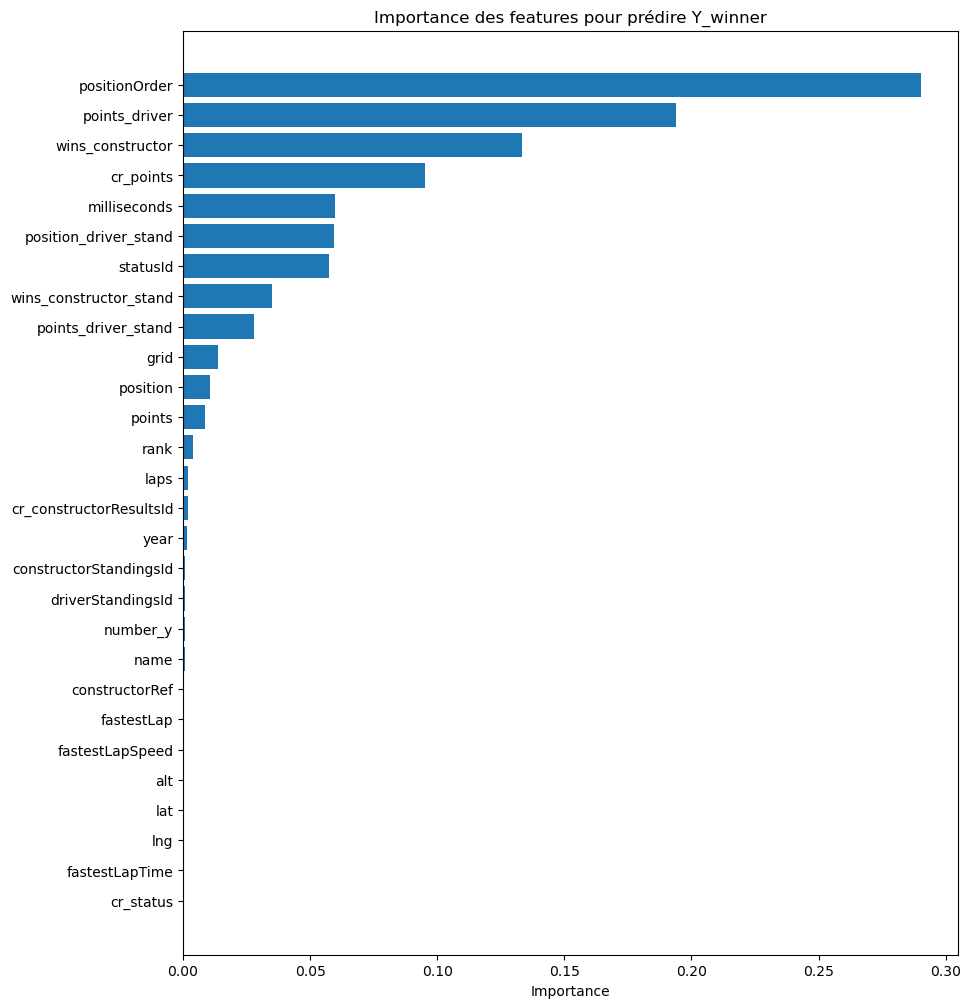

In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----------------------------
# 1. Préparation du dataset
# ----------------------------
df=df_merged.copy()
df_clean = df.copy()

# Colonnes à supprimer (IDs, URLs, dates non utiles, textes trop uniques)
drop_cols = ['resultId','raceId','driverId','constructorId','circuitId',
             'race_url','driver_url','constructor_url','circuit_url',
             'time_x','time_y','date','fp1_date','fp2_date','fp3_date',
             'quali_date','sprint_date','fp1_time','fp2_time','fp3_time',
             'quali_time','sprint_time','name_x','name_y','location','country',
             'circuitRef','code','driverRef','surname','forename','dob','status',
             'positionText_driver','positionText_driver_stand','positionText',
             'round','nationality_x','nationality_y','number_x','position_driver','positionText_driver'
]

df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], errors='ignore')

# ----------------------------
# 2. Encodage des colonnes non numériques
# ----------------------------

label_enc = LabelEncoder()
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = label_enc.fit_transform(df_clean[col].astype(str))

# ----------------------------
# 3. Séparation X / y
# ----------------------------

X = df_clean.drop(columns=['Y_winner'])
y = df_clean['Y_winner']

# ----------------------------
# 4. Modèle Random Forest
# ----------------------------

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

model.fit(X, y)

# ----------------------------
# 5. Importance des features
# ----------------------------

importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importances)

# ----------------------------
# 6. Visualisation graphique
# ----------------------------

plt.figure(figsize=(10, 12))
plt.barh(importances['feature'], importances['importance'])
plt.gca().invert_yaxis()
plt.title("Importance des features pour prédire Y_winner")
plt.xlabel("Importance")
plt.show()


In [91]:
df_merged = df_merged.drop(columns=['number_x', 'position_driver', 'positionText_driver','lat','alt','fastestLapSpeed',])

df_merged.to_csv("C:/Users/Eric/Documents/Esilv/MachineLearningA4/Projet/dfmerged.csv", index=False)


so we can drop number_x represente le numéro de la voiture 

positiondriver car c'est un doublon de position order, la difference est que positiondriver affiche nan pour une course non finie tandis que positionorder affiche la position finale

positiontextdriver, meme raison que positiondriver


                    feature  importance
22                   points    0.166004
17        driverStandingsId    0.068680
24  cr_constructorResultsId    0.068617
21   constructorStandingsId    0.067251
18      points_driver_stand    0.065131
4              milliseconds    0.055554
20         wins_constructor    0.045404
25                cr_points    0.041870
12                      lng    0.038932
10                     year    0.038622
8           fastestLapSpeed    0.037880
11                      lat    0.033111
23                 position    0.030968
13                      alt    0.029388
7            fastestLapTime    0.028743
3                      laps    0.027282
5                fastestLap    0.021627
6                      rank    0.018549
0                      grid    0.018207
19    position_driver_stand    0.017363
15           constructorRef    0.017208
16                     name    0.017106
1             positionOrder    0.013225
2             points_driver    0.012901


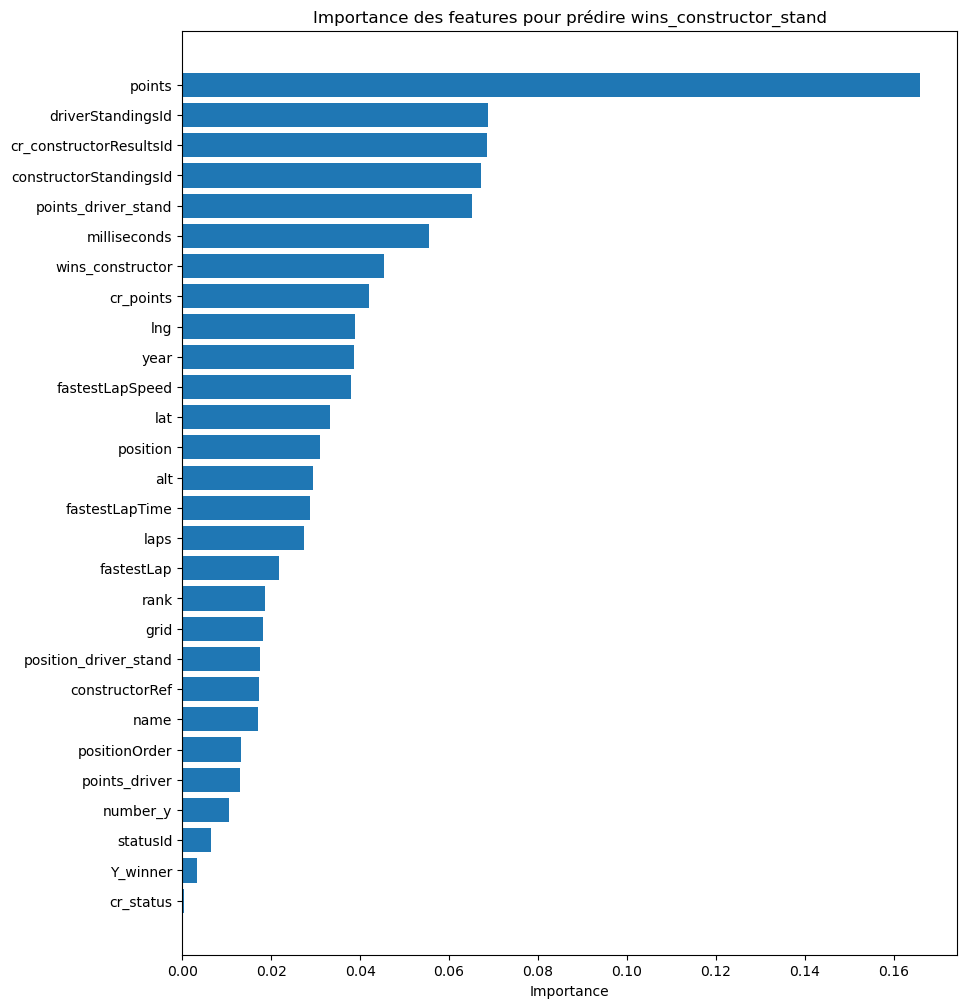

In [125]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----------------------------
# 1. Préparation du dataset
# ----------------------------
df=df_merged.copy()
df_clean = df.copy()

# Colonnes à supprimer (IDs, URLs, dates non utiles, textes trop uniques)
drop_cols = ['resultId','raceId','driverId','constructorId','circuitId',
             'race_url','driver_url','constructor_url','circuit_url',
             'time_x','time_y','date','fp1_date','fp2_date','fp3_date',
             'quali_date','sprint_date','fp1_time','fp2_time','fp3_time',
             'quali_time','sprint_time','name_x','name_y','location','country',
             'circuitRef','code','driverRef','surname','forename','dob','status',
             'positionText_driver','positionText_driver_stand','positionText',
             'round','nationality_x','nationality_y','number_x','position_driver','positionText_driver'
]

df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], errors='ignore')
df_clean['wins_constructor_stand'] = df_clean['wins_constructor_stand'].fillna(0)

# ----------------------------
# 2. Encodage des colonnes non numériques
# ----------------------------

label_enc = LabelEncoder()
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = label_enc.fit_transform(df_clean[col].astype(str))

# ----------------------------
# 3. Séparation X / y
# ----------------------------

X = df_clean.drop(columns=['wins_constructor_stand'])
y = df_clean['wins_constructor_stand']

# ----------------------------
# 4. Modèle Random Forest
# ----------------------------

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

model.fit(X, y)

# ----------------------------
# 5. Importance des features
# ----------------------------

importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importances)

# ----------------------------
# 6. Visualisation graphique
# ----------------------------

plt.figure(figsize=(10, 12))
plt.barh(importances['feature'], importances['importance'])
plt.gca().invert_yaxis()
plt.title("Importance des features pour prédire wins_constructor_stand")
plt.xlabel("Importance")
plt.show()
